In [1]:
!pip install --upgrade tables
!pip install eli5

     |████████████████████████████████| 4.3MB 4.9MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 4.5MB/s 


## Wczytujemy biblioteki

In [0]:
import pandas as pd
import numpy as np

np.random.seed(2019) 

#modele (algorytmy)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#walidacja wyniku (po to, żeby walczyć z przeuczeniem się modelu)
from sklearn.model_selection import train_test_split

#metryka sukcesu
from sklearn.metrics import accuracy_score # metryka sukcesu

#wizualizacja
import matplotlib.pyplot as plt

# umożliwia prezentowanie wykresów w notebooku
%matplotlib inline 

## Wczytujemy dane
Przygotowanie `targetu`

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/Predykcja płci po imieniu/gender_prediction_by_name/polish_names.csv"
df = pd.read_csv(path)

In [10]:
df.head(10)

,name,gender
0,Abdon,m
1,Abel,m
2,Abercjusz,m
3,Abraham,m
4,Absalon,m
5,Achacjusz,m
6,Achacy,m
7,Achilles,m
8,Ada,f
9,Adalbert,m


In [0]:
df['target'] = df['gender'].map(lambda x: int(x == 'm'))

In [0]:
def train_and_predict_model(X_train, X_test, y_train, y_test, model, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Distribution:")
    print( pd.Series(y_pred).value_counts() )
    
    return success_metric(y_test, y_pred)

## Feature engineering 

Tworzymy nowe cechy na podstawie już istniejących.

In [0]:
vowels = ['a', 'ą', 'e', 'ę', 'i', 'o', 'u', 'y']

def how_many_vowels(name):
    return sum( map(lambda x: int(x in vowels), name.lower()) )
    
def first_is_vowel(name):
    return name.lower()[0] in vowels

def last_is_vowel(name):
    return name.lower()[-1] in vowels

def get_all_vowels(name):
    all_vowels = [letter for letter in name.lower() if letter in vowels]
    
    return ''.join(all_vowels)

def get_all_consonants(name):
    all_consonants = [letter for letter in name.lower() if letter not in vowels]
    
    return ''.join(all_consonants)

def feature_engineering(df):
    df['len_name'] = df['name'].map(lambda x: len(x))
    
    df['first_is_vowel'] = df['name'].map(first_is_vowel)
    df['last_is_vowel'] = df['name'].map(last_is_vowel)
    
    df['first_letter'] = df['name'].map(lambda x: x.lower()[0])
    df['first_letter_cnt'] = pd.factorize(df['first_letter'])[0]
    
    df['last_letter'] = df['name'].map(lambda x: x.lower()[-1])
    df['last_letter_cnt'] = pd.factorize(df['last_letter'])[0]
    
    df['all_vowels'] = df['name'].map(get_all_vowels)
    df['all_vowels_cnt'] = pd.factorize(df['all_vowels'])[0]

    df['all_consonants'] = df['name'].map(get_all_consonants)
    df['all_consonants_cnt'] = pd.factorize(df['all_consonants'])[0]
    
    
    return df 

In [0]:
df_fe = feature_engineering(df.copy())

In [17]:
df_fe

,name,gender,target,len_name,first_is_vowel,last_is_vowel,first_letter,first_letter_cnt,last_letter,last_letter_cnt,all_vowels,all_vowels_cnt,all_consonants,all_consonants_cnt
0,Abdon,m,1,5,True,False,a,0,n,0,ao,0,bdn,0
1,Abel,m,1,4,True,False,a,0,l,1,ae,1,bl,1
2,Abercjusz,m,1,9,True,False,a,0,z,2,aeu,2,brcjsz,2
3,Abraham,m,1,7,True,False,a,0,m,3,aaa,3,brhm,3
4,Absalon,m,1,7,True,False,a,0,n,0,aao,4,bsln,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,Zbigniewa,f,0,9,False,True,z,23,a,6,iiea,429,zbgnw,1160
1701,Zygfryda,f,0,8,False,True,z,23,a,6,yya,282,zgfrd,1183
1702,Hermenia,f,0,8,False,True,h,25,a,6,eeia,77,hrmn,1230
1703,Hermes,m,1,6,False,False,h,25,s,5,ee,195,hrms,1289


Wybieramy jawnie cechy, które wydają się sensowne (w zmiennej `features`).


In [18]:
features = ['len_name', 'first_is_vowel', 'last_is_vowel', 'first_letter_cnt', 'last_letter_cnt', 'all_vowels_cnt', 'all_consonants_cnt']
X = df_fe[ features ]
y = df_fe['target']

train_and_predict_model(X, X, y, y, LogisticRegression(solver='lbfgs', max_iter=300))

Distribution:
1    964
0    741
dtype: int64


0.9524926686217009

## Train & Test

Zbiór danych - **treningowy** i **testowy**.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1193, 7) (1193,)
Test: (512, 7) (512,)


In [20]:
train_and_predict_model(X_train, X_test, y_train, y_test, LogisticRegression(solver='lbfgs', max_iter=300))

Distribution:
1    314
0    198
dtype: int64


0.962890625

## Krzywe uczenia się

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

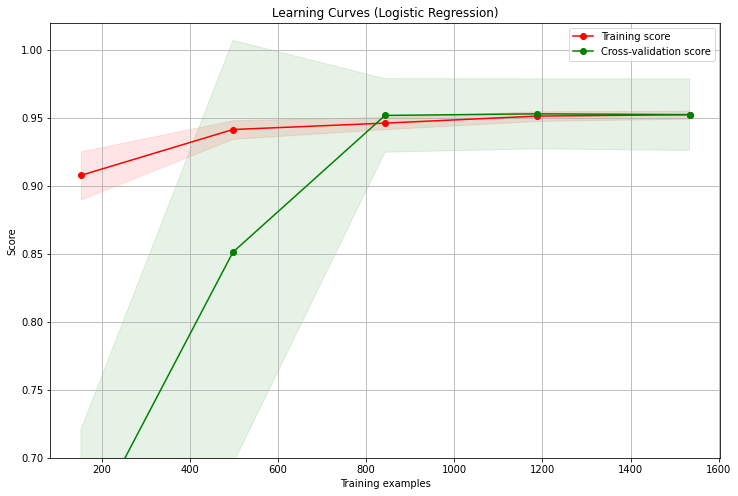

In [22]:
plt = plot_learning_curve(LogisticRegression(solver='lbfgs', max_iter=300), "Learning Curves (Logistic Regression)", X, y, ylim=(0.7, 1.02), cv=10, n_jobs=4)
plt.show()

In [23]:
train_and_predict_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Distribution:
1    327
0    185
dtype: int64


0.984375

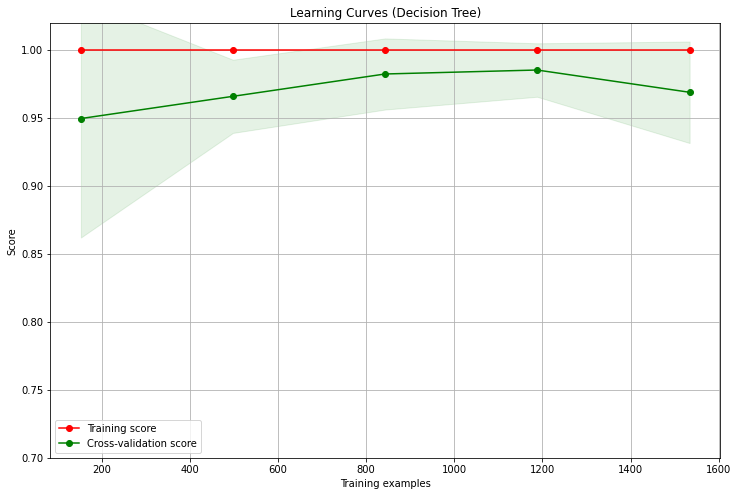

In [24]:
plt = plot_learning_curve(DecisionTreeClassifier(), "Learning Curves (Decision Tree)", X, y, ylim=(0.7, 1.02), cv=10)
plt.show()

## Ważność cech

In [0]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Trenujemy model (w tym przypadku drzewa decyzyjne) i sprawdzamy ważność cech. 

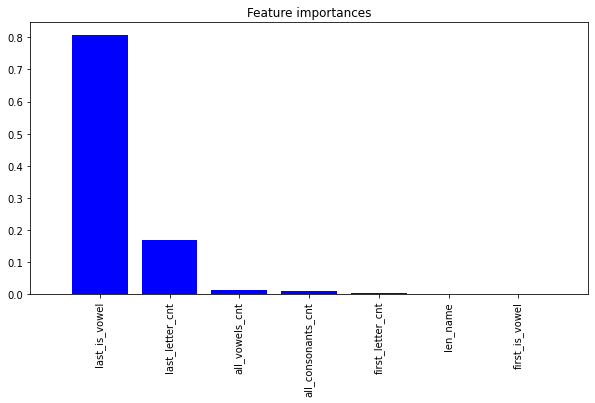

In [26]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

draw_feature_importances(model, features)